# FUNCTIONS SETUPS

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from typing import Tuple, Union
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score
import geopandas as gpd
import contextily as ctx
import matplotlib.ticker as mticker
from pyproj import Transformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier


In [2]:
# --- 1. Define the Global Font Size (Base Unit) ---
BASE_FONT_SIZE = 16 

# --- 2. Set Figure Defaults ---
# Set the default size for all figures (matches your (6, 4) default)
# plt.rcParams['figure.figsize'] = (6, 4) 
# Set the DPI for screen rendering (optional, but good practice)
plt.rcParams['figure.dpi'] = 100 
# Set default behavior to make titles, labels, etc., fit nicely
plt.rcParams['figure.autolayout'] = True 
# Set default line width to match your plot function (lw=2.5)
plt.rcParams['lines.linewidth'] = 2.5 

# --- 3. Set Axes and Label Defaults (including Bold) ---
# Axes Label Font Size (e.g., "Elevation Angle (Degrees)")
plt.rcParams['axes.labelsize'] = BASE_FONT_SIZE + 2 # 18
# Make Axes Labels always bold (the specific request)
plt.rcParams['axes.labelweight'] = 'bold' 
# Axes Title Font Size (for ax.set_title())
plt.rcParams['axes.titlesize'] = BASE_FONT_SIZE + 4 # 20 

# --- 4. Set Tick and Legend Defaults ---
# X-axis Tick Label Font Size (the numbers on the axis)
plt.rcParams['xtick.labelsize'] = BASE_FONT_SIZE + 2 # 18 
# Y-axis Tick Label Font Size (the numbers on the axis)
plt.rcParams['ytick.labelsize'] = BASE_FONT_SIZE + 2 # 18 
# Legend Font Size (matches your function's inline setting of 16)
plt.rcParams['legend.fontsize'] = BASE_FONT_SIZE 

In [3]:
from pathlib import Path

def find_project_root():
    for p in (Path.cwd(), Path.cwd().parent):
        if (p / "requirements.txt").exists():
            return p
    raise RuntimeError("Cannot locate project root")

PROJECT_ROOT = find_project_root()


## raw data preprocess

In [4]:
def clean_data(df: pd.DataFrame, timestamp_col='datapointTimestamp') -> pd.DataFrame:
    """
    Clean GNSS signal dataframe according to paper standards:
    - Convert signal columns to numeric safely.
    - Remove physically invalid measurements:
        • CNR (cn0DbHz/basebandCn0DbHz) ≤ 10 dB-Hz.
        • Missing or invalid carrier frequency in same rows.
    - Drop first 20 seconds of capture (to skip initialization noise).
    - Preserve feature structure and order.
    """
    df = df.copy()

    # Identify relevant signal columns (CNR only, case-insensitive)
    signal_cols = [c for c in df.columns if any(x in c.lower() for x in [
        'cn0dbhz', 'basebandcn0dbhz'
    ])]

    # Convert all relevant columns to numeric
    for col in signal_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # --- 2. Remove invalid CNRs (C/N₀) ---
    bad_cnr = np.zeros(len(df), dtype=bool)
    for col in [c for c in df.columns if 'cn0dbhz' in c.lower()]:
        bad_cnr |= df[col].le(10) | df[col].isna()  # threshold 10 dB-Hz

    # --- 3. Remove rows with missing/invalid carrier frequency ---
    if 'carrierFreqHz' in df.columns:
        bad_freq = df['carrierFreqHz'].isna() | (df['carrierFreqHz'] <= 0)
    else:
        bad_freq = np.zeros(len(df), dtype=bool)

    # Combine all anomaly conditions
    bad_rows = bad_cnr | bad_freq

    # Drop them
    df = df.loc[~bad_rows].copy()

    # --- 4. Timestamp cleanup ---
    if timestamp_col in df.columns:
        df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce')
        df = df.dropna(subset=[timestamp_col])
        df = df.sort_values(timestamp_col)

        # Drop first 20 seconds
        if not df.empty:
            t0 = df[timestamp_col].min()
            df = df[df[timestamp_col] >= t0 + pd.Timedelta(seconds=20)]

    df = df.reset_index(drop=True)
    return df



# ==========================================================
# 1. LOAD DATA
# ==========================================================
InputData = Union[str, pd.DataFrame]
def load_data(data: InputData) -> pd.DataFrame:
    if isinstance(data, str):
        print(f"Loading data from file path: {data}")
        return pd.read_csv(data)
    elif isinstance(data, pd.DataFrame):
        print("Using provided DataFrame directly.")
        return data.copy()
    else:
        raise ValueError("Input 'data' must be a file path (str) or a pandas DataFrame.")

# ==========================================================
# 2. NORMALIZATION
# ==========================================================
def normalize_features(X: pd.DataFrame) -> Tuple[pd.DataFrame, MinMaxScaler]:
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
    return X_scaled, scaler

# ==========================================================
# 3. LABEL ENCODING
# ==========================================================
def encode_labels(y: pd.Series) -> Tuple[np.ndarray, LabelEncoder]:
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return y_encoded, le


# ==========================================================
# 2. BOOLEAN CONVERSION & LABEL EXTRACTION
# ==========================================================


# Task 1: Data Transformation
def cast_boolean_columns_to_float(df: pd.DataFrame) -> pd.DataFrame:
    """Converts specific boolean-like columns to float (1.0/0.0)."""
    bool_cols = ['hasAlmanacData', 'hasEphemerisData', 'usedInFix']
    for col in bool_cols:
        if col in df.columns:
            # Note: .copy() might be used here to avoid modifying the original DF,
            # but for this example, we keep the original function's behavior.
            df[col] = df[col].astype(float)
    return df

# Task 2: Label Extraction and Indexing
def extract_time_indexed_labels(
    df: pd.DataFrame, 
    timestamp_col: str = 'datapointTimestamp', 
    target_col: str = 'label'
) -> pd.DataFrame:
    """Extracts unique labels and sets the timestamp as the index."""
    # 1. Drop duplicates based on timestamp
    df_labels = df.drop_duplicates(subset=[timestamp_col])
    
    # 2. Select only the necessary columns
    df_labels = df_labels[[timestamp_col, target_col]]
    
    # 3. Set the index
    df_labels = df_labels.set_index(timestamp_col)
    
    return df_labels

# Combining the steps
def process_data_and_extract_labels(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Applies both transformation and extraction."""
    # Process the main DataFrame
    processed_df = cast_boolean_columns_to_float(df.copy()) 
    
    # Extract the labels
    df_labels = extract_time_indexed_labels(processed_df)
    
    return processed_df, df_labels



# ==========================================================
# 4. AGGREGATION
# ==========================================================
# ==========================================================
# 4. AGGREGATION (updated to include coords)
# ==========================================================
def aggregate_gnss_data(df: pd.DataFrame,
                        df_labels: pd.DataFrame,
                        timestamp_col='datapointTimestamp') -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
    """
    Aggregate GNSS features per timestamp for ML training.
    Returns:
        X  - numeric features (per timestamp)
        y  - labels (aligned with X)
        coords - latitude/longitude for mapping (aligned with X)
    """
    agg_funcs = {
        'basebandCn0DbHz': ['mean', 'min', 'max', 'std'],
        'cn0DbHz': ['mean', 'min', 'max', 'std'],
        'elevationDegrees': ['mean', 'min', 'max', 'std'],
        'usedInFix': ['sum'],
        'svid': ['count']
    }
    valid_agg_funcs = {k: v for k, v in agg_funcs.items() if k in df.columns}

    # --- Aggregate numeric GNSS features
    X = df.groupby(timestamp_col).agg(valid_agg_funcs)
    X.columns = ['_'.join(col) for col in X.columns]
    X = X.rename(columns={'svid_count': 'Num_Satellites'})

    if 'usedInFix_sum' in X.columns:
        X['UsedInFix_Ratio'] = X['usedInFix_sum'] / X['Num_Satellites']
        X = X.drop(columns=['usedInFix_sum'])

    # --- Join labels (timestamp-based)
    X = X.join(df_labels, how='inner')
    y = X['label']
    X = X.drop(columns=['label'])

    # --- Optionally attach coordinates for later mapping
    coords = (
        df.groupby(timestamp_col)[['latitude', 'longitude']]
        .mean()
        .loc[X.index]
    )

    # --- Drop NaNs, keep numeric
    X = X.select_dtypes(include=[np.number]).dropna(axis=0, how='any')
    y = y.loc[X.index]
    coords = coords.loc[X.index]

    return X, y, coords


# ==========================================================
# 7. PIPELINE WRAPPER
# ==========================================================
def preprocess_sigcap_data(data: InputData):
    df = load_data(data)
    df, df_labels = process_data_and_extract_labels(df)
    X, y, coords = aggregate_gnss_data(df, df_labels)
    y_encoded, le = encode_labels(y)
    
    print("Preprocessing complete.")
    print(f"Features: {X.shape}, Labels: {y_encoded.shape}")
    print(f"Encoded classes: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    
    return X, y_encoded, le, coords


## **raw data plotting**
roc curves and scatterplot

In [5]:


# ==========================================================
# (a) ROC of CNR values for a specific satellite
# ==========================================================
def roc_cnr_single_satellite(df, svid, constellation=None,
    color='orange', show_thresholds=True, save_path=None, dpi=300):
    """
    Plots ROC curve using individual cn0DbHz values for a given satellite SVID.
    Optionally filter by constellationType (e.g., 'BeiDou', 'GPS', etc.)
    You can also add a subtitle below the graph using the 'subtitle' argument.
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc

    # Filter for selected satellite
    df_sat = df[df['svid'] == svid]
    if constellation:
        df_sat = df_sat[df_sat['constellationType'] == constellation]
    
    if df_sat.empty:
        print(f"No data found for SVID {svid} (constellation={constellation})")
        return None

    # Prepare ground truth and scores
    y_true = (df_sat['label'] == 'outdoor').astype(int)
    scores = df_sat['cn0DbHz']

    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    if show_thresholds:
        step = max(1, len(thresholds)//4)
        # Plot dots for threshold points
        ax.scatter(fpr[::step], tpr[::step], color=color, s=40, edgecolor='black', zorder=3)
        # Annotate threshold values near the dots
        for i in range(0, len(thresholds), step):
            ax.text(fpr[i] + 0.02, tpr[i], f'{thresholds[i]:.1f}', fontsize=18, color='black', va='center')

    ax.plot(fpr, tpr, label=f'(AUC = {roc_auc:.3f})', color=color)
    ax.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Pr. of False Alarm \n(O Classified as I)')
    plt.ylabel('Pr. of Detection \n(I Classified as I)')
    ax.legend(loc="lower right")
    ax.grid(True)

    # Title and subtitle
    fig.suptitle(f'ROC: CNR values for SVID {svid}', fontsize=18, y=0.0)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    
    plt.show()

    return roc_auc



In [6]:
# ==========================================================
# (b) ROC of mean CNR per timestamp
# ==========================================================
def roc_mean_cnr_per_timestamp(df, color='orange', show_thresholds=True, cn0='cn0DbHz', save_path=None, dpi=300):
    """
    Aggregates mean CNR (cn0DbHz) per timestamp, computes ROC curve.
    Matching style with roc_cnr_single_satellite().
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc

    # Aggregate mean CNR per timestamp per label
    df_mean = df.groupby(['datapointTimestamp', 'label'], as_index=False)[cn0].mean()
    df_mean.rename(columns={cn0: 'mean_cnr'}, inplace=True)

    # Ground truth and scores
    y_true = (df_mean['label'] == 'outdoor').astype(int)
    scores = df_mean['mean_cnr']

    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    if show_thresholds:
        step = max(1, len(thresholds)//4)
        # Dots for threshold points
        ax.scatter(fpr[::step], tpr[::step], color=color, s=40, edgecolor='black', zorder=3)
        # Annotate threshold values
        for i in range(0, len(thresholds), step):
            ax.text(fpr[i] + 0.02, tpr[i], f'{thresholds[i]:.1f}', fontsize=18, color='black', va='center')

    ax.plot(fpr, tpr, label=f'(AUC = {roc_auc:.3f})', color=color)
    ax.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Pr. of False Alarm \n(O Classified as I)')
    plt.ylabel('Pr. of Detection \n(I Classified as I)')
    ax.legend(loc="lower right")
    ax.grid(True)

    # Title
    fig.suptitle('ROC: Mean CNR per Timestamp', fontsize=18, y=0.0)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    
    plt.show()

    return roc_auc


In [7]:
# ==========================================================
# (c) ROC of number of satellites per timestamp
# ==========================================================
def roc_num_satellites_per_timestamp(df, color='orange', show_thresholds=True, save_path=None, dpi=300):
    """
    Aggregates number of unique satellites (svid) per timestamp, computes ROC curve.
    Matching style with roc_cnr_single_satellite() and roc_mean_cnr_per_timestamp().
    """
    import matplotlib.pyplot as plt
    from sklearn.metrics import roc_curve, auc

    # Aggregate number of unique satellites per timestamp per label
    df_count = df.groupby(['datapointTimestamp', 'label'], as_index=False)['svid'].nunique()
    df_count.rename(columns={'svid': 'num_satellites'}, inplace=True)

    # Ground truth and scores
    y_true = (df_count['label'] == 'outdoor').astype(int)
    scores = df_count['num_satellites']

    # Compute ROC
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    # Plot
    fig, ax = plt.subplots(figsize=(6, 6))

    if show_thresholds:
        step = max(1, len(thresholds)//4)
        # Dots for threshold points
        ax.scatter(fpr[::step], tpr[::step], color=color, s=40, edgecolor='black', zorder=3)
        # Annotate threshold values near dots
        for i in range(0, len(thresholds), step):
            ax.text(fpr[i] + 0.02, tpr[i], f'{thresholds[i]:.1f}', fontsize=18, color='black', va='center')

    ax.plot(fpr, tpr, label=f'(AUC = {roc_auc:.3f})', color=color)
    ax.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Pr. of False Alarm \n(O Classified as I)')
    plt.ylabel('Pr. of Detection \n(I Classified as I)')
    ax.legend(loc="lower right")
    ax.grid(True)

    # Title
    fig.suptitle('ROC: Number of Satellites per Timestamp', fontsize=18, y=0.0)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    
    plt.show()

    return roc_auc


In [8]:
def plot_cnr_vs_elevation(elevation, cnr, figsize=(6, 4),
                          save_path=None, dpi=300, color="tab:blue",
                          what="indoor"):
    """
    Plot CNR vs. Elevation Angle with a linear regression fit.

    Parameters
    ----------
    elevation : np.ndarray
        Elevation angle values in degrees.
    cnr : np.ndarray
        CNR (dB-Hz) values.
    figsize : tuple
        Figure dimensions.
    save_path : str, optional
        Path to save the plot (if None, displays the figure).
    dpi : int
        Resolution when saving.
    color : str
        Color for the scatter points.
    """
    # --- Linear regression (least squares) ---
    coeffs = np.polyfit(elevation, cnr, 1)
    fit_line = np.poly1d(coeffs)
    label = f"Fit: y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}"

    # --- Plot setup ---
    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(elevation, cnr, s=3, alpha=0.5, color=color, label="Data Points")
    ax.plot(np.sort(elevation), fit_line(np.sort(elevation)), 
            'r--', lw=2.5, label=label)

    

    # --- Axes & style ---
    ax.set_xlabel("Elevation Angle (Degrees)", fontsize=18, fontweight="bold")
    ax.set_ylabel("CNR (dB-Hz)", fontsize=18, fontweight="bold")
    ax.legend(fontsize=16, loc="lower right")
    ax.grid(True, linestyle=":", alpha=0.6)
    plt.tight_layout()
    fig.suptitle(f"{what} environments", y=0.0, fontsize=18)

    # --- Save or show ---
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    
    plt.show()

    return coeffs


## **ML pred plotting**
map

In [9]:
def deg2dms(value, axis='lon'):
    deg = int(abs(value))
    minutes = (abs(value) - deg) * 60
    hemi = ''
    if axis == 'lon':
        hemi = 'E' if value >= 0 else 'W'
    else:
        hemi = 'N' if value >= 0 else 'S'
    return f"{deg}°{int(minutes):02d}′{hemi}"

In [10]:
def plot_geographic_track(gdf, figsize=(6, 5), basemap=ctx.providers.Esri.WorldGrayCanvas,
                          zoom=15, save_path=None, dpi=300, edgecolors='black', linewidth=0.6, mticker_m=mticker,
                          width_manual=0, locatt="upper right"):
    """
    Plot indoor/outdoor GNSS track over a basemap.

    Parameters
    ----------
    gdf : geopandas.GeoDataFrame
        GeoDataFrame containing 'label' and 'geometry' columns (EPSG:4326).
    figsize : tuple
        Size of the figure in inches.
    basemap : str
        Basemap provider key (from contextily.providers).
    zoom : int
        Basemap zoom level.
    save_path : str, optional
        Path to save the figure.
    dpi : int
        Resolution when saving.
    """
    # Convert to Web Mercator (required by contextily)
    gdf_web = gdf.to_crs(epsg=3857)

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Plot outdoor first (so indoor overlays)
    gdf_web[gdf_web["final_label"] == "outdoor"].plot(
        ax=ax, 
        color="red", 
        markersize=50, 
        label="Outdoor",
        edgecolors=edgecolors,
        linewidth=linewidth
    )

    gdf_web[gdf_web["final_label"] == "indoor"].plot(
        ax=ax, 
        color="blue", 
        markersize=120, 
        label="Indoor",
        edgecolors=edgecolors,
        linewidth=linewidth
    )

    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    # Expand horizontally by, say, 10%
    x_pad = (x_max - x_min) * width_manual
    ax.set_xlim(x_min - x_pad, x_max + x_pad)


    # Add basemap
    ctx.add_basemap(ax, source=basemap, zoom=zoom)

    transformer = Transformer.from_crs(3857, 4326, always_xy=True)

    def format_lon(x, pos):
        lon_deg = transformer.transform(x, y_min)[0]
        return deg2dms(lon_deg, axis='lon')

    def format_lat(y, pos):
        lat_deg = transformer.transform(x_min, y)[1]
        return deg2dms(lat_deg, axis='lat')


    ax.xaxis.set_major_formatter(mticker_m.FuncFormatter(format_lon))
    ax.yaxis.set_major_formatter(mticker_m.FuncFormatter(format_lat))

    #ax.set_xticks([ax.get_xlim()[0], ax.get_xlim()[1]])
    ax.xaxis.set_major_locator(mticker_m.MaxNLocator(nbins=2))
    ax.yaxis.set_major_locator(mticker_m.MaxNLocator(nbins=3))


    ax.set_xlabel('Longitude', fontsize=22, fontweight="bold")
    ax.set_ylabel('Latitude', fontsize=22, fontweight="bold")
    ax.tick_params(axis='both', labelsize=18)

    ax.legend(loc=locatt)
    ax.set_axisbelow(True)
    plt.tight_layout()


    # Save or show
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    
    plt.show()

# plc

In [11]:
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

In [12]:
DATA_DIR = PROJECT_ROOT / "data" / "gps_csvs"

import pandas as pd

df_pulang = pd.read_csv(DATA_DIR / "pulang.csv")
df_pergi = pd.read_csv(DATA_DIR / "pergi.csv")
df_thepark = pd.read_csv(DATA_DIR / "thepark.csv")
df_pakuwon = pd.read_csv(DATA_DIR / "pakuwon.csv")
df_superindo = pd.read_csv(DATA_DIR / "superindo.csv")

In [13]:
df_pulang = clean_data(df_pulang)
df_pergi = clean_data(df_pergi)
df_thepark = clean_data(df_thepark)
df_pakuwon = clean_data(df_pakuwon)
df_superindo = clean_data(df_superindo)

df_pulang['label'] = 'outdoor'
df_pergi['label'] = 'outdoor'
df_thepark['label'] = 'indoor'
df_pakuwon['label'] = 'indoor'
df_superindo['label'] = 'indoor'

In [14]:
dict_of_dfs = {
    10: df_pulang,
    11: df_pergi,
    20: df_thepark,
    21: df_pakuwon,
    22: df_superindo
}

In [15]:
choiceA = [11, 21, 22]
choiceB = [10, 20]

for i in (choiceA+choiceB):
    print(i, 'label' in dict_of_dfs[i].columns)

df_groupA = pd.concat([dict_of_dfs[i] for i in choiceA], ignore_index=True, sort=False)
df_groupB = pd.concat([dict_of_dfs[i] for i in choiceB], ignore_index=True, sort=False)
df_main = pd.concat([dict_of_dfs[i] for i in (choiceA + choiceB)], ignore_index=True, sort=False)

11 True
21 True
22 True
10 True
20 True


# roc calls

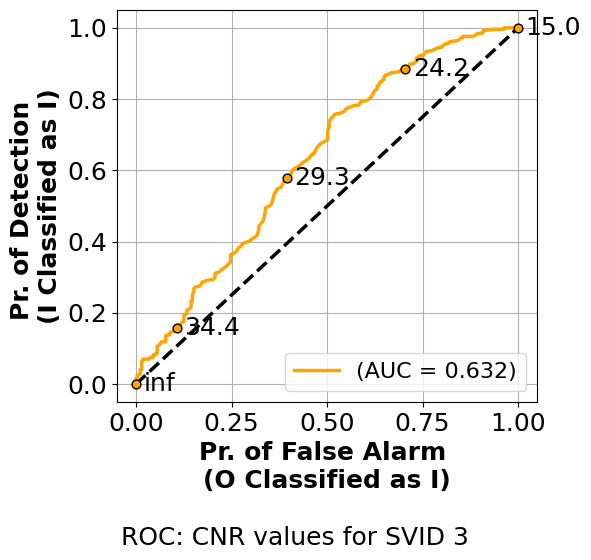

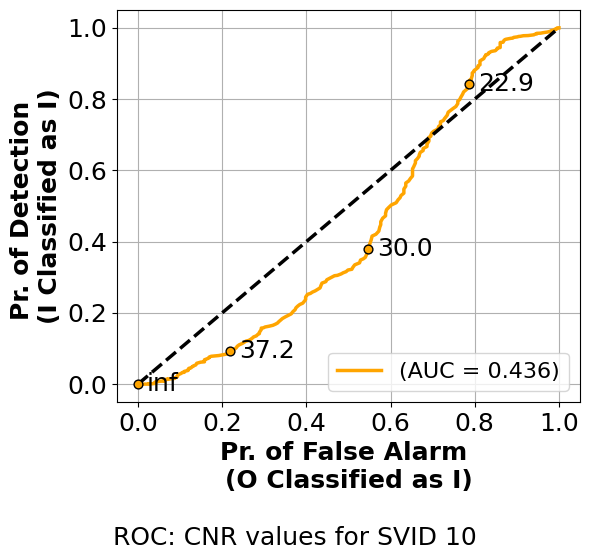

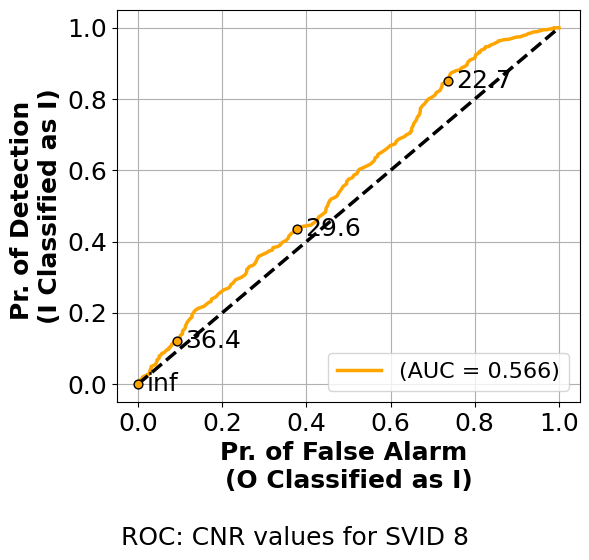

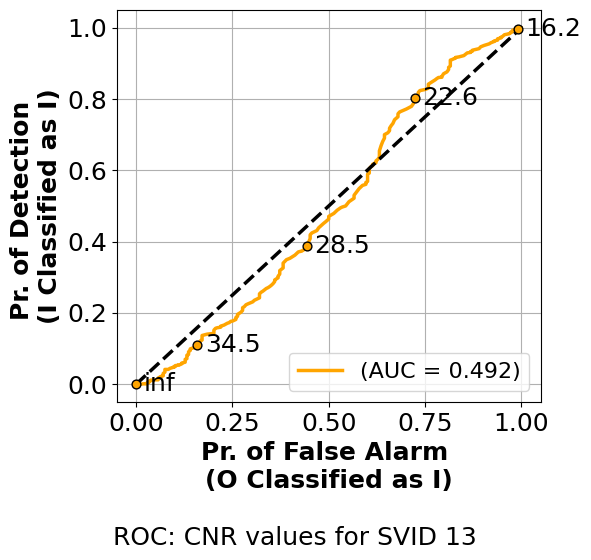

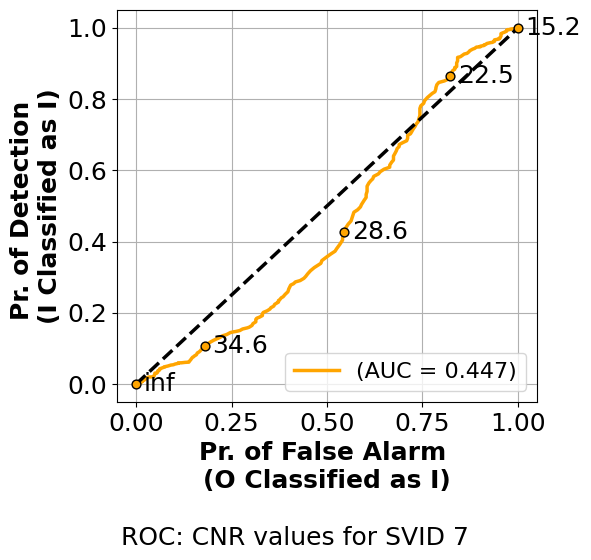

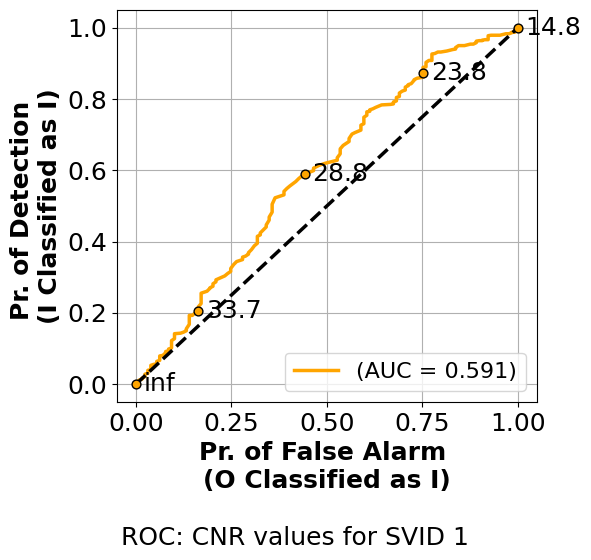

In [16]:
r = 0

for i in df_main.svid.unique():
    if r > 5:
        break

    out_cnr_svid = RESULTS_DIR / f"roc_cnr_vs_svid_{i}.png"
    roc_cnr_single_satellite(df_main, i, save_path=str(out_cnr_svid))

    assert out_cnr_svid.exists(), "Geographic track plot was not created"

    r += 1

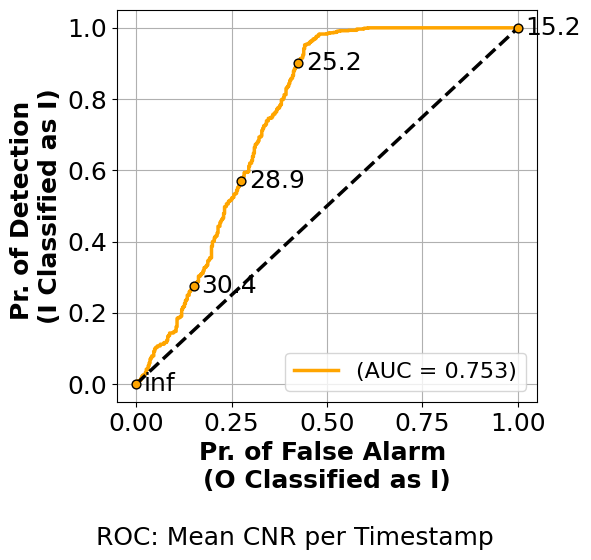

0.752966342600489

In [17]:
out_mean_cnr = RESULTS_DIR / "roc_mean_cnr.png"
roc_mean_cnr_per_timestamp(df_main, save_path=str(out_mean_cnr))

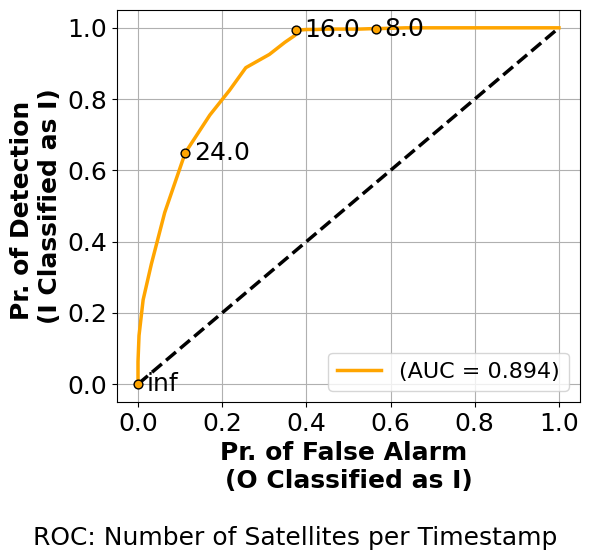

0.8942790948888509

In [18]:
out_svid_num = RESULTS_DIR / "roc_svid_num.png"
roc_num_satellites_per_timestamp(df_main, save_path=str(out_svid_num))

# scatterplot calls

In [19]:
df_indoor = df_main.query('label == \'indoor\'')
df_outdoor = df_main.query('label == \'outdoor\'')

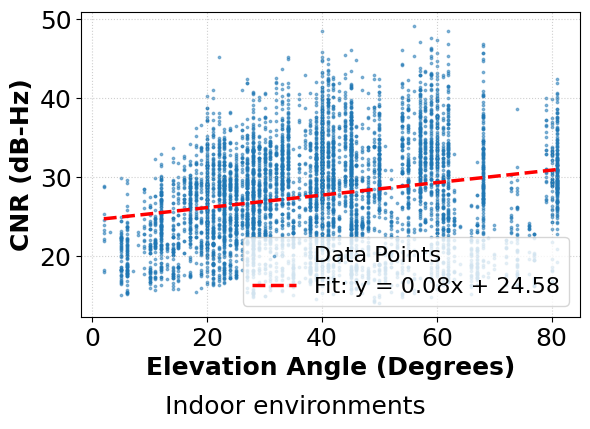

array([ 0.07909443, 24.58448545])

In [20]:
out_scatter_indoor = RESULTS_DIR / "scatter_cnr_indoor.png"
plot_cnr_vs_elevation(cnr=df_indoor['cn0DbHz'],elevation=df_indoor['elevationDegrees'], what="Indoor",
                      save_path=str(out_scatter_indoor))

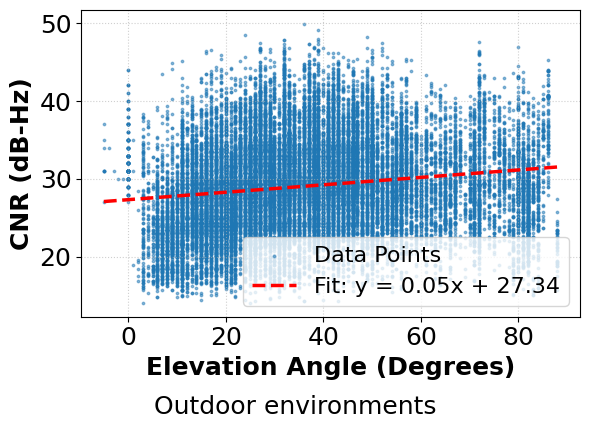

array([ 0.04768541, 27.33737211])

In [21]:
out_scatter_outdoor = RESULTS_DIR / "scatter_cnr_outdoor.png"
plot_cnr_vs_elevation(cnr=df_outdoor['cn0DbHz'],elevation=df_outdoor['elevationDegrees'], what="Outdoor",
                      save_path=str(out_scatter_outdoor))

# map calls

In [22]:
predict_model=Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', RandomForestClassifier(random_state=30))
])

# TRAIN on Group A
X_J, y_J, le_J, coords_J = preprocess_sigcap_data(df_groupA)
predict_model.fit(X_J, y_J)

# TEST / PREDICT on Group B
X_K, y_K, _, coords_K = preprocess_sigcap_data(df_groupB)
y_pred_K = predict_model.predict(X_K)

# Make dataframe for plotting
pred_map_df = coords_K.copy()               # keep lat/long and index
pred_map_df['label'] = le_J.inverse_transform(y_K)
pred_map_df['final_label'] = le_J.inverse_transform(y_pred_K)        # add predicted labels

# Optionally, reset index for export or folium mapping
pred_map_df = pred_map_df.reset_index().rename(columns={'datapointTimestamp': 'timestamp'})

Using provided DataFrame directly.
Preprocessing complete.
Features: (869, 14), Labels: (869,)
Encoded classes: {'indoor': np.int64(0), 'outdoor': np.int64(1)}
Using provided DataFrame directly.
Preprocessing complete.
Features: (340, 14), Labels: (340,)
Encoded classes: {'indoor': np.int64(0), 'outdoor': np.int64(1)}


In [23]:
df_fitted_track = pred_map_df.copy().query('label == \'outdoor\'')
gdf_fitted = gpd.GeoDataFrame(
    df_fitted_track,
    geometry=gpd.points_from_xy(df_fitted_track.longitude, df_fitted_track.latitude),
    crs="EPSG:4326"
)

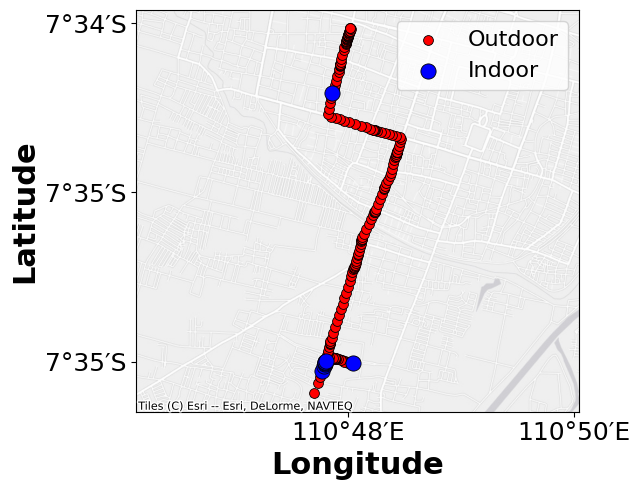

In [24]:
out_geo_track = RESULTS_DIR / "geo_track.png"
plot_geographic_track(gdf=gdf_fitted, figsize=(12,5), width_manual=1.8, save_path=str(out_geo_track))

# plc

In [25]:
here = [out_geo_track,
        #out_cnr_svid,
        out_mean_cnr,
        out_scatter_indoor,
        out_scatter_outdoor,
        out_svid_num]
for i in here:
    assert i.exists(), "Geographic track plot was not created"
